In [76]:
# Imports

import torch

from torchtext.data.metrics import bleu_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
# # Mount google drive

# from google.colab import drive
# drive.mount('/content/drive/')

In [78]:
# %cd /content/drive/MyDrive/Colab Notebooks/CSE-676
# %ls

In [79]:
# Helper functions

from helpers.preprocessing import preprocess_data, split_data
from helpers.model_decoder import Encoder, DecoderRNN
from helpers.training import prepare_dataloader, train
from helpers.evaluation import generate_translation, evaluate

In [80]:
# Global Variables

languages = ['eng', 'fra', 'spa', 'deu', 'por']
LANGUAGE1 = languages[0]
LANGUAGE2 = languages[1]
FILEPATH = f'data/{LANGUAGE1}-{LANGUAGE2}.txt'

# Model tuning parameters

HIDDEN_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT = 0.1


losses_list = []  # List to store losses for each language pair
accuracies_list = []  # List to store accuracies for each language pair

Data preprocessing

In [81]:
input_language, output_language, line_pairs = preprocess_data(FILEPATH, LANGUAGE1, LANGUAGE2)

train_pairs, test_pairs = split_data(line_pairs, test_size=0.2)

Number of translation pairs: 17917
fra 5699
eng 3703
Number of training pairs: 14333
Number of testing pairs: 3584


Model

In [82]:
# TODO

# basic, gru, lstm, decoder without attention, diff attension mechanism

In [83]:
encoder = Encoder(input_language.n_words, HIDDEN_SIZE, DROPOUT).to(device)
decoder = DecoderRNN(HIDDEN_SIZE, output_language.n_words).to(device)

encoder, decoder

(Encoder(
   (encoder_layers): Sequential(
     (0): Embedding(5699, 128)
     (1): Dropout(p=0.1, inplace=False)
     (2): GRU(128, 128, batch_first=True)
   )
 ),
 DecoderRNN(
   (embedding): Embedding(3703, 128)
   (gru): GRU(128, 128, batch_first=True)
   (out): Linear(in_features=128, out_features=3703, bias=True)
 ))

Training

In [84]:
input_language, output_language, train_dataloader = prepare_dataloader(input_language, output_language, train_pairs, BATCH_SIZE)

losses_list, accuracies_list = train(train_dataloader, encoder, decoder, epochs=60, learning_rate=LEARNING_RATE, print_every=5, plot_every=5)


Epoch [5/60], Avg. Loss: 1.6806, Avg. Accuracy: 0.5553
Epoch [10/60], Avg. Loss: 0.8914, Avg. Accuracy: 0.7063
Epoch [15/60], Avg. Loss: 0.5819, Avg. Accuracy: 0.7904
Epoch [20/60], Avg. Loss: 0.4021, Avg. Accuracy: 0.8495
Epoch [25/60], Avg. Loss: 0.2891, Avg. Accuracy: 0.8883
Epoch [30/60], Avg. Loss: 0.2147, Avg. Accuracy: 0.9157
Epoch [35/60], Avg. Loss: 0.1658, Avg. Accuracy: 0.9333
Epoch [40/60], Avg. Loss: 0.1320, Avg. Accuracy: 0.9457
Epoch [45/60], Avg. Loss: 0.1088, Avg. Accuracy: 0.9536
Epoch [50/60], Avg. Loss: 0.0922, Avg. Accuracy: 0.9599
Epoch [55/60], Avg. Loss: 0.0809, Avg. Accuracy: 0.9637
Epoch [60/60], Avg. Loss: 0.0725, Avg. Accuracy: 0.9665


In [85]:
# print( accuracies_list)
# print(losses_list)

In [86]:
print( accuracies_list)
print(losses_list)

[0.39712117471528396, 0.5394416238206154, 0.5842877537219712, 0.6144821441988773, 0.6410377510385024, 0.6659296072475124, 0.6868391958180823, 0.7066324613848846, 0.7271448965791141, 0.7448021210137071, 0.7617079741957644, 0.7766173266210835, 0.7914193402960402, 0.8052123697175918, 0.8170840355076586, 0.8299968871762395, 0.8403765443362708, 0.8504127174951429, 0.8585060592724579, 0.8680592080546998, 0.8739628393246246, 0.8821098504771208, 0.8887433852495089, 0.8948616940201582, 0.9018279789186694, 0.9062288676835224, 0.9121432328284834, 0.9165763232184451, 0.9203868488563056, 0.9232849951160869, 0.9260865365005421, 0.930294215514743, 0.9334821764005024, 0.936970685787276, 0.9394609447956807, 0.9415540504277449, 0.9429172525573457, 0.9468565846956409, 0.9476830930734305, 0.9494219808292992, 0.9506241748333566, 0.9527387482154933, 0.9530714983416163, 0.9552397410989342, 0.9562916608524844, 0.9576119274819402, 0.9591683393621931, 0.9601343881154536, 0.9612614449942574, 0.9615297918701631, 

Save Model

In [87]:
# Save models

encoder_filepath = f'models/encoder-{LANGUAGE1}-{LANGUAGE2}.pth'
decoder_filepath = f'models/decoder-{LANGUAGE1}-{LANGUAGE2}.pth'

torch.save(encoder.state_dict(), encoder_filepath)
torch.save(decoder.state_dict(), decoder_filepath)

Save List

In [88]:
# Save list as a pickle object
import pickle

loss_filename = f'objects/decoder_loss_{LANGUAGE2}_{LANGUAGE1}.pkl'
accuracy_filename = f'objects/decoder_accuracy_{LANGUAGE2}_{LANGUAGE1}.pkl'

with open(loss_filename, 'wb') as file:
    pickle.dump(losses_list, file)

with open(accuracy_filename, 'wb') as file:
    pickle.dump(losses_list, file)

# Load pickle object back into a list

# with open(loss_filename, 'rb') as file:
#     loss_filename = pickle.load(file)

# with open(accuracy_filename, 'rb') as file:
#     accuracy_filename = pickle.load(file)

# loss_filename, accuracy_filename

Load Model

In [89]:
# Load models

encoder.load_state_dict(torch.load(encoder_filepath))
decoder.load_state_dict(torch.load(decoder_filepath))

<All keys matched successfully>

Evaluation

In [90]:
# Evaluate random training pairs

encoder.eval()
decoder.eval()

references_corpus, candidate_corpus = evaluate(input_language, output_language, encoder, decoder,
                                               train_pairs, evaluate_train=True)

Input Sequence> je lis des nouvelles
Target Sequence = ['i', 'am', 'reading', 'short', 'stories']
Predicted sequence < ['i', 'am', 'reading', 'this', 'book', 'on', 'his', 'music']
Input Sequence> il n est plus en colere
Target Sequence = ['he', 'is', 'not', 'angry', 'anymore']
Predicted sequence < ['he', 'is', 'not', 'angry', 'anymore']
Input Sequence> vous vous trouvez sur la liste
Target Sequence = ['you', 're', 'on', 'the', 'list']
Predicted sequence < ['you', 're', 'on', 'the', 'list']
Input Sequence> je suis tres heureuse d etre a boston
Target Sequence = ['i', 'm', 'quite', 'happy', 'to', 'be', 'in', 'boston']
Predicted sequence < ['i', 'am', 'quite', 'proud', 'of', 'my', 'children', 'together']
Input Sequence> je ne suis pas invitee a des fetes
Target Sequence = ['i', 'm', 'not', 'invited', 'to', 'parties']
Predicted sequence < ['i', 'm', 'not', 'invited', 'to', 'parties']
Input Sequence> on est comme une famille
Target Sequence = ['we', 're', 'like', 'a', 'family']
Predicted se

In [91]:
# Evaluate testing pairs

candidate_corpus, references_corpus = evaluate(input_language, output_language, encoder, decoder,
                                                test_pairs, evaluate_train=False, iterations=len(test_pairs))

Input Sequence> je suis vraiment amoureuse de toi
Target Sequence = ['i', 'm', 'really', 'in', 'love', 'with', 'you']
Predicted sequence < ['i', 'm', 'really', 'in', 'just', 'a', 'lot', 'in', 'common']
Input Sequence> elle a peur des chats
Target Sequence = ['she', 'is', 'afraid', 'of', 'cats']
Predicted sequence < ['she', 's', 'afraid', 'of', 'your', 'dog']
Input Sequence> je suis habitue a travailler toute la nuit
Target Sequence = ['i', 'm', 'used', 'to', 'working', 'all', 'night']
Predicted sequence < ['i', 'm', 'used', 'to', 'working', 'all', 'night']
Input Sequence> ils sont amis
Target Sequence = ['they', 're', 'friends']
Predicted sequence < ['they', 're', 'best', 'friends']
Input Sequence> je suis presque aveugle
Target Sequence = ['i', 'm', 'almost', 'blind']
Predicted sequence < ['i', 'm', 'almost', 'centimeters', 'tall', 'than', 'all']
Input Sequence> j essaye d arreter tom
Target Sequence = ['i', 'm', 'trying', 'to', 'stop', 'tom']
Predicted sequence < ['i', 'm', 'trying',

Benchmark

In [92]:
bleu = bleu_score(candidate_corpus, references_corpus)

bleu

0.29502639174461365

Analysis

In [93]:
bleu

0.29502639174461365

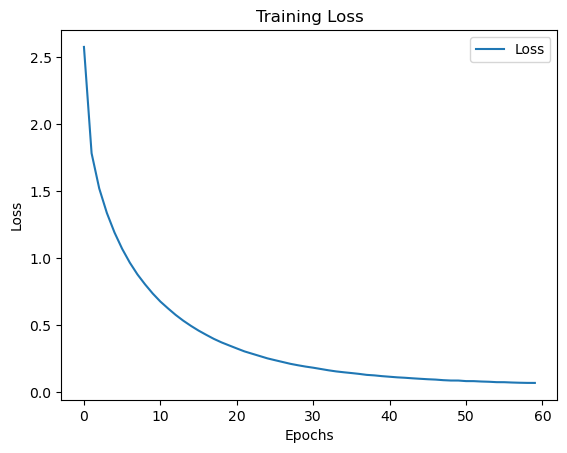

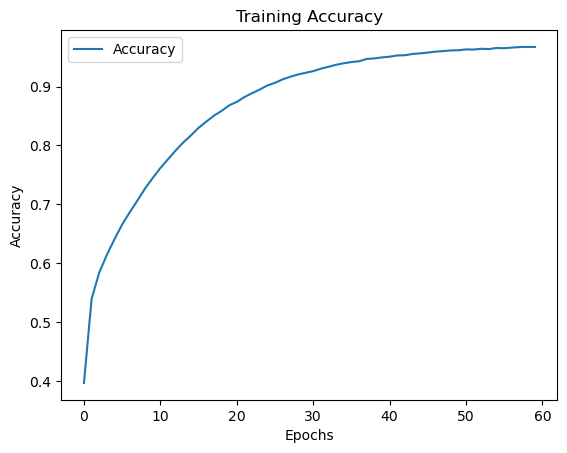

In [94]:
import matplotlib.pyplot as plt

# Plotting loss for the first language pair
plt.plot(losses_list, label='Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.savefig('training_loss.png')  # Save the loss plot as an image
plt.show()
plt.close()  # Close the plot to start a new one

# Plotting accuracies for the first language pair
plt.plot(accuracies_list, label='Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.savefig('training_accuracy.png')  # Save the accuracy plot as an image
plt.show()
plt.close()  # Close the plot

# # Display the saved images
# from IPython.display import Image, display
# display(Image(filename='training_loss.png'))
# display(Image(filename='training_accuracy.png'))
